In [479]:
%config InlineBackend.figure_format = 'retina'

In [480]:
import numpy as np
import time
from scipy.sparse import coo_matrix
from scipy.signal import convolve2d, convolve, gaussian
import matplotlib.pyplot as plt

import seaborn as sns
#sns.set(color_codes=True)

def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, axisbg='black')
    ax.plot(m.col, m.row, 's', color='white', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

In [525]:
def fastkde(x, y, gridsize=(200, 200), extents=None, nocorrelation=False, weights=None, adjust=1.):
    """
    A fft-based Gaussian kernel density estimate (KDE)
    for computing the KDE on a regular grid
    Note that this is a different use case than scipy's original
    scipy.stats.kde.gaussian_kde
    IMPLEMENTATION
    --------------
    Performs a gaussian kernel density estimate over a regular grid using a
    convolution of the gaussian kernel with a 2D histogram of the data.
    It computes the sparse bi-dimensional histogram of two data samples where
    *x*, and *y* are 1-D sequences of the same length. If *weights* is None
    (default), this is a histogram of the number of occurences of the
    observations at (x[i], y[i]).
    histogram of the data is a faster implementation than numpy.histogram as it
    avoids intermediate copies and excessive memory usage!
    This function is typically *several orders of magnitude faster* than
    scipy.stats.kde.gaussian_kde.  For large (>1e7) numbers of points, it
    produces an essentially identical result.
    Boundary conditions on the data is corrected by using a symmetric /
    reflection condition. Hence the limits of the dataset does not affect the
    pdf estimate.
    INPUTS
    ------
        x, y:  ndarray[ndim=1]
            The x-coords, y-coords of the input data points respectively
        gridsize: tuple
            A (nx,ny) tuple of the size of the output grid (default: 200x200)
        extents: (xmin, xmax, ymin, ymax) tuple
            tuple of the extents of output grid (default: extent of input data)
        nocorrelation: bool
            If True, the correlation between the x and y coords will be ignored
            when preforming the KDE. (default: False)
        weights: ndarray[ndim=1]
            An array of the same shape as x & y that weights each sample (x_i,
            y_i) by each value in weights (w_i).  Defaults to an array of ones
            the same size as x & y. (default: None)
        adjust : float
            An adjustment factor for the bw. Bandwidth becomes bw * adjust.
    OUTPUTS
    -------
        g: ndarray[ndim=2]
            A gridded 2D kernel density estimate of the input points.
        e: (xmin, xmax, ymin, ymax) tuple
            Extents of g
    """
    # Variable check
    x, y = np.asarray(x), np.asarray(y)
    x, y = np.squeeze(x), np.squeeze(y)

    if x.size != y.size:
        raise ValueError('Input x & y arrays must be the same size!')

    n = x.size

    if weights is None:
        # Default: Weight all points equally
        weights = np.ones(n)
    else:
        weights = np.squeeze(np.asarray(weights))
        if weights.size != x.size:
            raise ValueError('Input weights must be an array of the same size as input x & y arrays!')

    # Optimize gridsize ------------------------------------------------------
    #Make grid and discretize the data and round it to the next power of 2
    # to optimize with the fft usage
    if gridsize is None:
        gridsize = np.asarray([np.max((len(x), 512.)), np.max((len(y), 512.))])
    gridsize = 2 ** np.ceil(np.log2(gridsize))  # round to next power of 2
    #print(f"Gridsize: {gridsize}")
    
    nx, ny = gridsize + 2
    #print(f"nx: {nx}, ny: {ny}")

    # Make the sparse 2d-histogram -------------------------------------------
    # Default extents are the extent of the data
    if extents is None:
        xmin, xmax = x.min(), x.max()
        ymin, ymax = y.min(), y.max()
    else:
        xmin, xmax, ymin, ymax = map(float, extents)
    dx = (xmax - xmin) / (nx - 1)
    dy = (ymax - ymin) / (ny - 1)
    #print(f"xMin: {xmin}, xMax: {xmax}, yMin: {ymin}, yMax: {ymax}")
    
    
    # Basically, this is just doing what np.digitize does with one less copy
    # xyi contains the bins of each point as a 2d array [(xi,yi)]
    xyi = np.vstack((x,y)).T
    xyi -= [xmin, ymin]
    xyi /= [dx, dy]
    xyi = np.floor(xyi, xyi).T
    #print(f"bins: \n{xyi}")

    # Next, make a 2D histogram of x & y.
    # Exploit a sparse coo_matrix avoiding np.histogram2d due to excessive
    # memory usage with many points
    grid = coo_matrix((weights, xyi), shape=(nx, ny)).toarray()
    
    #ax = plot_coo_matrix(grid)
    #ax.figure.show()

    # Kernel Preliminary Calculations ---------------------------------------
    # Calculate the covariance matrix (in pixel coords)
    cov = np.cov(xyi) / 0.1

    if nocorrelation:
        cov[1,0] = 0
        cov[0,1] = 0
        
    #print(f"Covariance: \n{cov}")

    # Scaling factor for bandwidth
    scotts_factor = n ** (-1.0 / 6.) * adjust  # For 2D
    #print(f"Scotts Factor: {scotts_factor}")

    # Make the gaussian kernel ---------------------------------------------

    # First, determine the bandwidth using Scott's rule
    # (note that Silvermann's rule gives the # same value for 2d datasets)
    std_devs = np.diag(np.sqrt(cov))
    kern_nx, kern_ny = np.round(scotts_factor * 2 * np.pi * std_devs)

    # Determine the bandwidth to use for the gaussian kernel
    inv_cov = np.linalg.inv(cov * scotts_factor ** 2)

    # x & y (pixel) coords of the kernel grid, with <x,y> = <0,0> in center
    xx = np.arange(kern_nx, dtype=np.float) - kern_nx / 2.0
    yy = np.arange(kern_ny, dtype=np.float) - kern_ny / 2.0
    xx, yy = np.meshgrid(xx, yy)


    # Then evaluate the gaussian function on the kernel grid
    kernel = np.vstack((xx.flatten(), yy.flatten()))
    kernel = np.dot(inv_cov, kernel) * kernel
    kernel = np.sum(kernel, axis=0) / 2.0
    kernel = np.exp(-kernel)
    kernel = kernel.reshape((int(kern_ny), int(kern_nx)))
    
#     print(f"Standard Deviation: {std_devs}")
#     print(f"Kern_nx: {kern_nx}")
#     print(f"Kern_ny: {kern_ny}")
#     print(f"Bandwidth: \n{inv_cov}")
#     print(f"Meshgrid: {xx.shape}, {yy.shape}")
#     print(xx)
#     print(yy)
#     print(f"Kernel \n{kernel.shape}")
#     print(f"Kenel : \n{kernel}")

    #---- Produce the kernel density estimate --------------------------------

    # Convolve the histogram with the gaussian kernel
    # use boundary=symm to correct for data boundaries in the kde
    #print(f"Grid Before Norm: \n{grid.shape}")
    #print(f"GridCount: {np.count_nonzero(grid)}")
    
    grid = convolve2d(grid, kernel, mode='same', boundary='symm')

    #print(f"GridCount: {np.count_nonzero(grid)}")
    # Normalization factor to divide result by so that units are in the same
    # units as scipy.stats.kde.gaussian_kde's output.
    norm_factor = 2 * np.pi * cov * scotts_factor ** 2
    norm_factor = np.linalg.det(norm_factor)
    norm_factor = n * dx * dy * np.sqrt(norm_factor)

    # Normalize the result
    grid /= norm_factor
    
#     print(f"Normalization Factor: {norm_factor}")
#     print(f"Grid After Norm: \n{grid}")
#     print(f"Grid Shape: {grid.shape}")
    
    #gridPlot = plot_coo_matrix(grid)
    #gridPlot.figure.show()
    
    grid = np.rot90(grid)
    
    return grid

In [526]:
dataA = np.genfromtxt('/Users/joshisaacson/Desktop/Root/Projects/fastKde/example/data/vectors.Chest.csv', delimiter=',')
x = dataA[:,0]
y = dataA[:,1]

Default Kde Time: 40.280877113342285


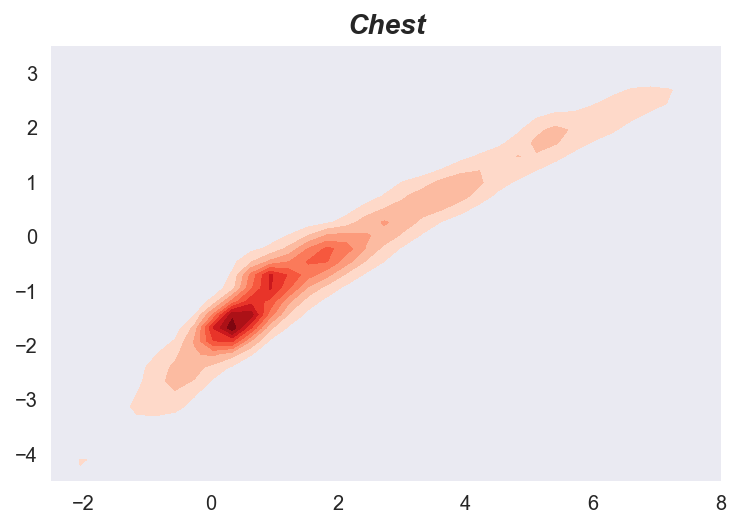

In [466]:
startA = time.time()

dataA = np.genfromtxt('/Users/joshisaacson/Desktop/Root/Projects/fastKde/example/data/vectors.Chest.csv', delimiter=',')
x = dataA[:,0]
y = dataA[:,1]

ax = sns.kdeplot(x,y, shade=True, cmap="Reds", shade_lowest=False)
ax.set(xlim=(-2.5, 8), ylim=(-4.5, 3.5))
ax.set_title('Chest', style='italic', fontweight='bold', fontsize=14)
plt.savefig('Chest.png', dpi = 900)

endA = time.time()
print(f"Default Kde Time: {endA - startA}")

Default Kde Time: 140.49395418167114


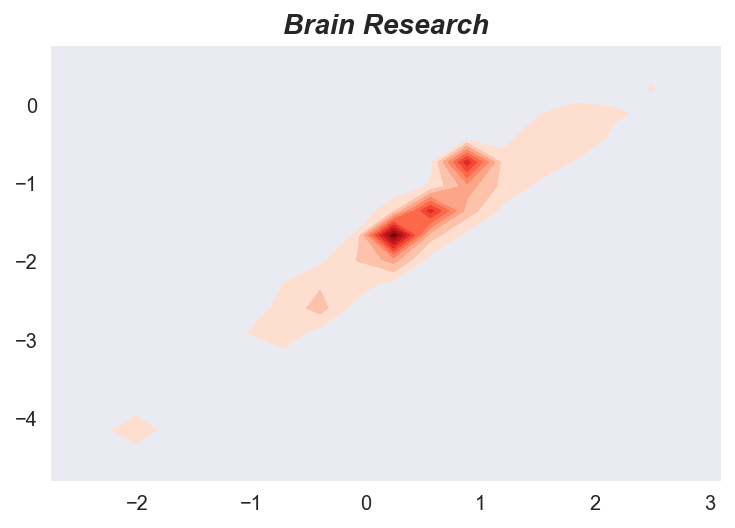

In [467]:
startB = time.time()

dataB = np.genfromtxt('/Users/joshisaacson/Desktop/Root/Projects/fastKde/example/data/vectors.Brain-research.csv', delimiter=',')
a = dataB[:,0]
b = dataB[:,1]

bx = sns.kdeplot(a,b, shade=True, cmap="Reds", shade_lowest=False)
bx.set(xlim=(-2.75, 3.1), ylim=(-4.8, 0.75))
bx.set_title('Brain Research', style='italic', fontweight='bold', fontsize=14)
plt.savefig('BrainResearch.png', dpi = 900)

endB = time.time()
print(f"Default Kde Time: {endB - startB}")

Default Kde Time: 42.605257987976074


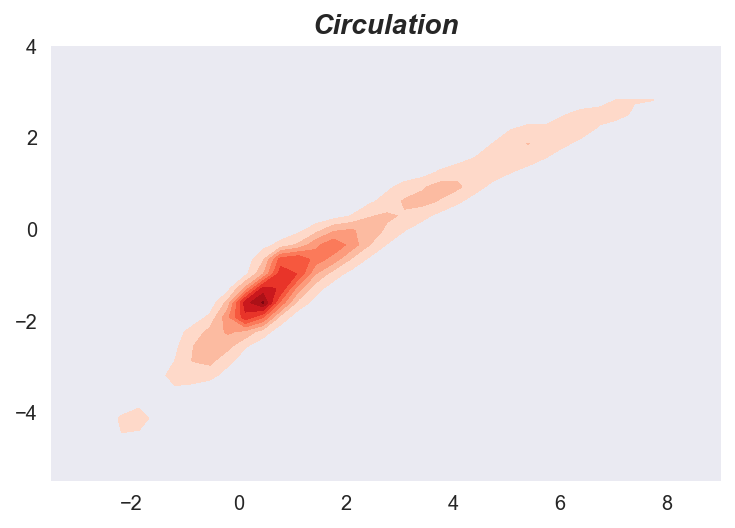

In [468]:
startC = time.time()

dataC = np.genfromtxt('/Users/joshisaacson/Desktop/Root/Projects/fastKde/example/data/vectors.Circulation.csv', delimiter=',')
c = dataC[:,0]
d = dataC[:,1]

cx = sns.kdeplot(c,d, shade=True, cmap="Reds", shade_lowest=False)
cx.set(xlim=(-3.5, 9), ylim=(-5.5, 4))
cx.set_title('Circulation', style='italic', fontweight='bold', fontsize=14)
plt.savefig('Circulation.png', dpi = 900)

endC = time.time()
print(f"Default Kde Time: {endC - startC}")

Default Kde Time: 63.943427085876465


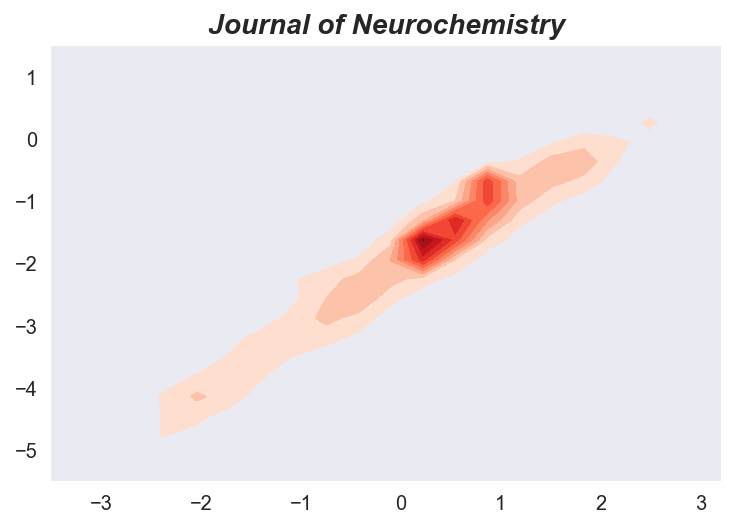

In [469]:
startD = time.time()

dataD = np.genfromtxt('/Users/joshisaacson/Desktop/Root/Projects/fastKde/example/data/vectors.Journal-of-neurochemistry.csv', delimiter=',')
e = dataD[:,0]
f = dataD[:,1]

dx = sns.kdeplot(e,f, shade=True, cmap="Reds", shade_lowest=False)
dx.set(xlim=(-3.5, 3.2), ylim=(-5.5, 1.5))
dx.set_title('Journal of Neurochemistry', style='italic', fontweight='bold', fontsize=14)
plt.savefig('JournalOfNeurochemistry.png', dpi = 900)

endD = time.time()
print(f"Default Kde Time: {endD - startD}")

Default Kde Time: 32.935893058776855


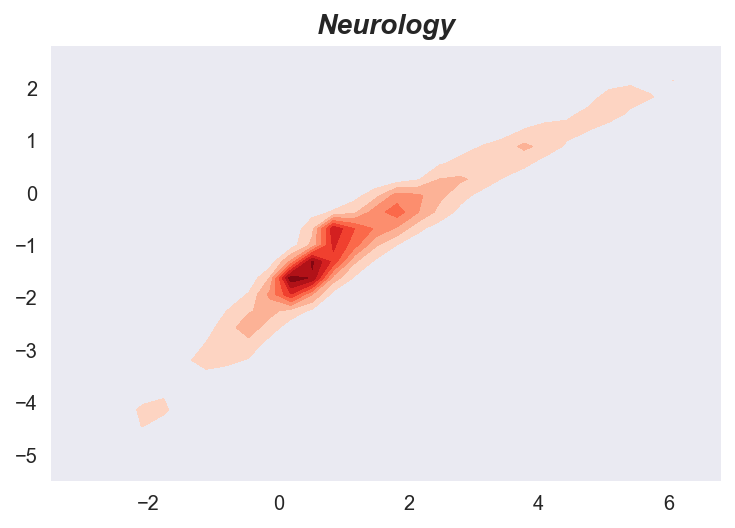

In [470]:
startE = time.time()

dataE = np.genfromtxt('/Users/joshisaacson/Desktop/Root/Projects/fastKde/example/data/vectors.Neurology.csv', delimiter=',')
h = dataE[:,0]
i = dataE[:,1]

ex = sns.kdeplot(h,i, shade=True, cmap="Reds", shade_lowest=False)
ex.set(xlim=(-3.5, 6.8), ylim=(-5.5, 2.8))
ex.set_title('Neurology', style='italic', fontweight='bold', fontsize=14)
plt.savefig('Neurology.png', dpi = 900)

endE = time.time()
print(f"Default Kde Time: {endE - startE}")

Default Kde Time: 74.30117559432983


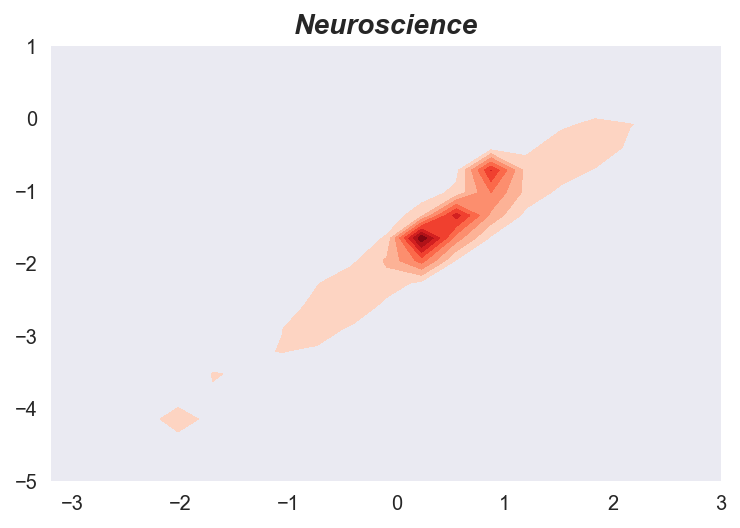

In [471]:
startF = time.time()

dataF = np.genfromtxt('/Users/joshisaacson/Desktop/Root/Projects/fastKde/example/data/vectors.Neuroscience.csv', delimiter=',')
j = dataF[:,0]
k = dataF[:,1]

fx = sns.kdeplot(j,k, shade=True, cmap="Reds", shade_lowest=False)
fx.set(xlim=(-3.2, 3.0), ylim=(-5, 1))
fx.set_title('Neuroscience', style='italic', fontweight='bold', fontsize=14)
plt.savefig('Neuroscience.png', dpi = 900)

endF = time.time()
print(f"Default Kde Time: {endF - startF}")

In [490]:
scipyKdeTime = np.array([
    40.280877113342285,
    140.49395418167114,
    42.605257987976074,
    63.943427085876465,
    32.935893058776855,
    74.30117559432983])

yAxis = np.array([1, 2, 3, 4, 5, 6])

Default Kde Time: 2.2415318489074707


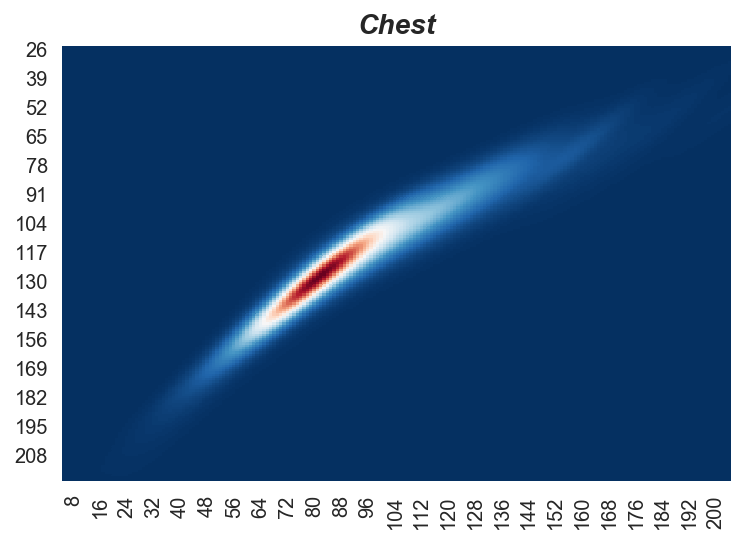

In [533]:
startAx = time.time()

gridA = fastkde(x, y)
ax = sns.heatmap(gridA, cmap="RdBu_r", cbar=False)
ax.set(xlim=(5, 205), ylim=(220, 25))
ax.set_title('Chest', style='italic', fontweight='bold', fontsize=14)
plt.savefig('ChestFastKde.png', dpi = 900)

endAx = time.time()
print(f"Default Kde Time: {endAx - startAx}")

Default Kde Time: 1.691056251525879


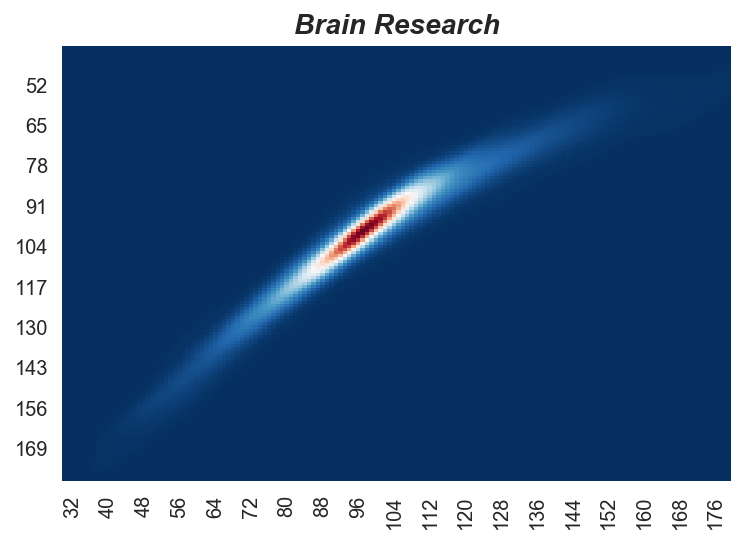

In [536]:
startBx = time.time()

gridB = fastkde(a, b)
ax = sns.heatmap(gridB, cmap="RdBu_r", cbar=False)
ax.set(xlim=(30, 180), ylim=(180, 40))
ax.set_title('Brain Research', style='italic', fontweight='bold', fontsize=14)
plt.savefig('BrainResearchKde.png', dpi = 900)

endBx = time.time()
print(f"Default Kde Time: {endBx - startBx}")

Default Kde Time: 2.043262243270874


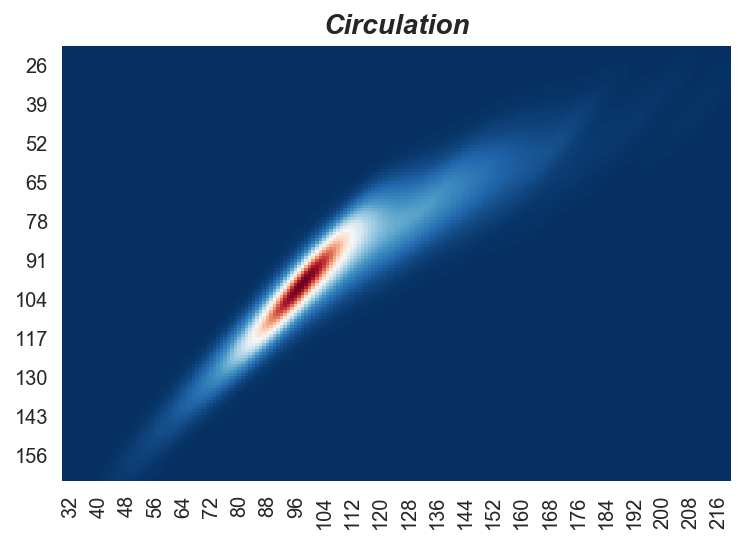

In [548]:
startCx = time.time()

gridC = fastkde(c, d)
ax = sns.heatmap(gridC, cmap="RdBu_r", cbar=False)
ax.set(xlim=(30, 220), ylim=(165, 20))
ax.set_title('Circulation', style='italic', fontweight='bold', fontsize=14)
plt.savefig('CirculationKde.png', dpi = 900)

endCx = time.time()
print(f"Default Kde Time: {endCx - startCx}")

Default Kde Time: 1.9155550003051758


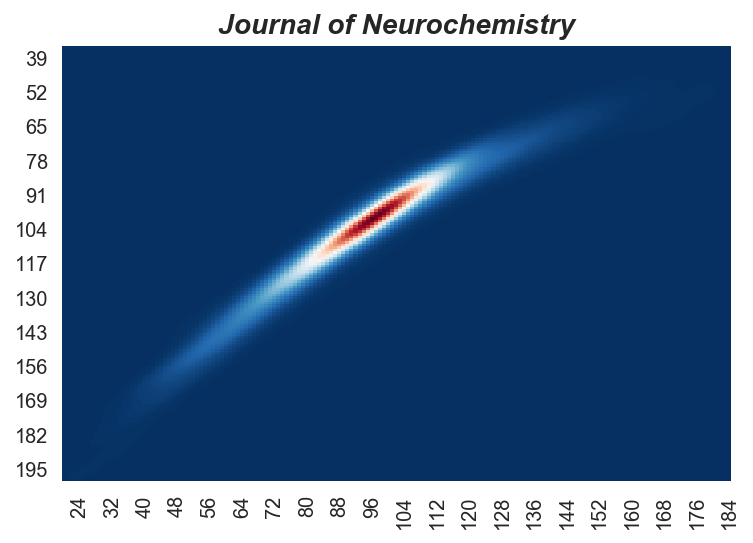

In [551]:
startDx = time.time()

gridD = fastkde(e, f)
ax = sns.heatmap(gridD, cmap="RdBu_r", cbar=False)
ax.set(xlim=(20, 185), ylim=(200, 35))
ax.set_title('Journal of Neurochemistry', style='italic', fontweight='bold', fontsize=14)
plt.savefig('JournalOfNeurochemistryKde.png', dpi = 900)

endDx = time.time()
print(f"Default Kde Time: {endDx - startDx}")

Default Kde Time: 1.9321861267089844


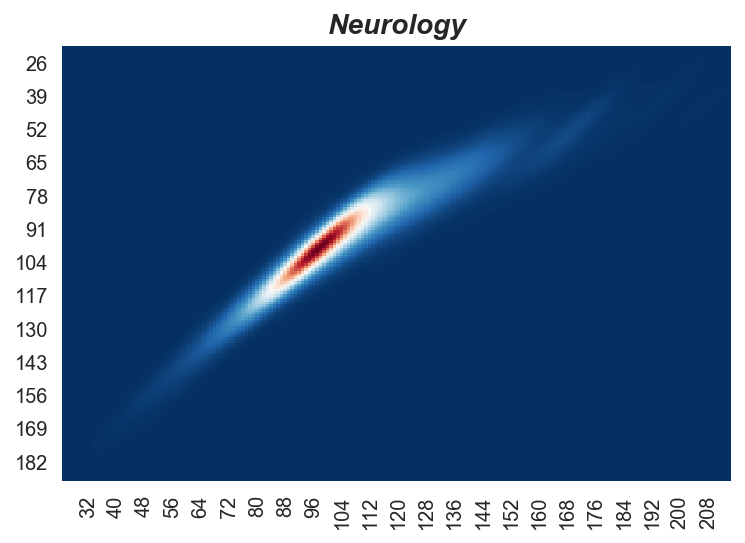

In [555]:
startEx = time.time()

gridE = fastkde(h, i)
ax = sns.heatmap(gridE, cmap="RdBu_r", cbar=False)
ax.set(xlim=(25, 215), ylim=(190, 20))
ax.set_title('Neurology', style='italic', fontweight='bold', fontsize=14)
plt.savefig('NeurologyKde.png', dpi = 900)

endEx = time.time()
print(f"Default Kde Time: {endEx - startEx}")

Default Kde Time: 1.6491000652313232


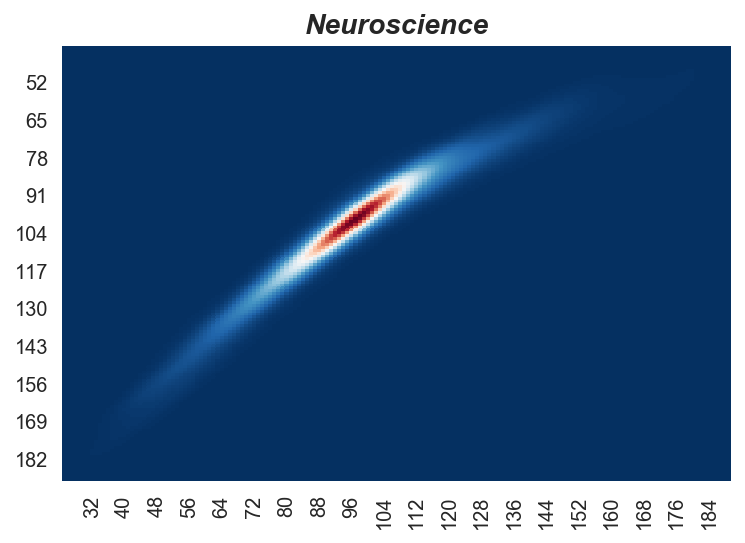

In [558]:
startFx = time.time()

gridF = fastkde(j, k)
ax = sns.heatmap(gridF, cmap="RdBu_r", cbar=False)
ax.set(xlim=(25, 190), ylim=(190, 40))
ax.set_title('Neuroscience', style='italic', fontweight='bold', fontsize=14)
plt.savefig('NeuroscienceKde.png', dpi = 900)

endFx = time.time()
print(f"Default Kde Time: {endFx - startFx}")

In [559]:
fastKdeTime = np.array([
    2.2415318489074707,
    1.691056251525879,
    2.043262243270874,
    1.9155550003051758,
    1.9321861267089844,
    1.6491000652313232
]) scipyKdeTime

No handles with labels found to put in legend.


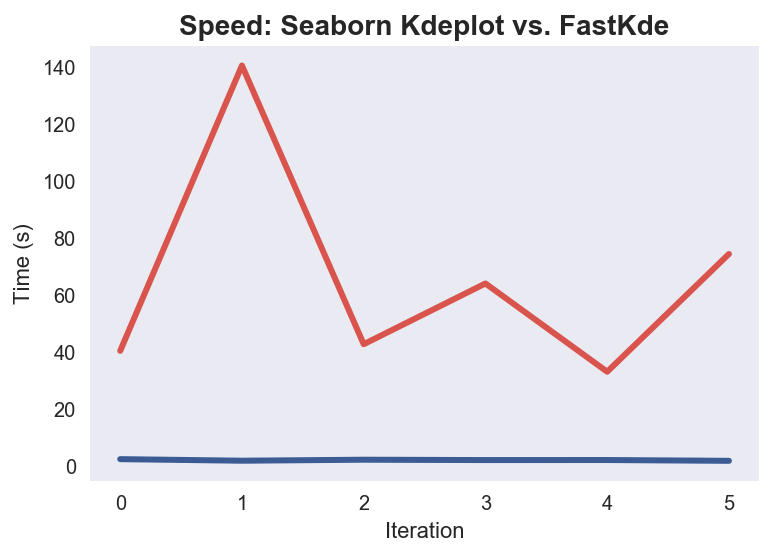

In [587]:
plt.plot(scipyKdeTime, sns.xkcd_rgb["pale red"], lw=3)
plt.plot(fastKdeTime, sns.xkcd_rgb["denim blue"], lw=3)
plt.title("Speed: Seaborn Kdeplot vs. FastKde", fontsize=14, fontweight='bold')
plt.xlabel("Iteration")
plt.ylabel("Time (s)")
plt.legend(loc='upper right')